# Simulation of FMCW
In this notebook, I present the underlying formulae and algorithms behind implementing FMCW RADAR in Python. In a second notebook, I will replace the simulated signal with a real signal obtained from a USRP by way of SoapySDR.

## Signal Generation
In this section of the notebook, I build primitives that I'll use in the analysis section to generate signals.

### CW Frequency Modulator
I begin by implementing a frequency modulator. This is essentially a function $r(x)$ that controls the frequency of the oscillator.

Without the modulator, the oscillator (and in turn, the wave) would be defined as $f(t) = cos(2 \pi f_0 t + \phi_t)$, where $\phi_t$ is the phase shift of the transmitted signal. 

With the modulator, we replace the $f_0$ term, so the oscillator is defined as $f(t) = cos(2 \pi \int_0^t r(t) + \phi_t)$. Note that this still actually supports constant frequencies - if we set the frequency delta to 0, the frequency modulator actually just returns a constant, so $r(t) = f_0$ for all $t$ and $\int_0^t r(t) = f_0 t$.

In [18]:
import numpy as np


class FrequencyModulator:
    def __init__(
        self,
        base_frequency,
        initial_time=0,
        frequency_delta=0,
        chirp_duration=1,
        rising_fraction=0.5,
        falling_fraction=0.5,
    ):
        self.frequency = base_frequency
        self.chirp_duration = chirp_duration
        self.initial_time = initial_time

        self.rising_duration = chirp_duration * rising_fraction
        self.rising_slope = frequency_delta / self.rising_duration

        self.falling_duration = chirp_duration * falling_fraction
        self.falling_slope = -frequency_delta / self.falling_duration

    def evaluate(self, t: np.ndarray):
        adjusted_times = (t - self.initial_time) % self.chirp_duration

        rising_signals = (adjusted_times <= self.rising_duration) * (
            self.frequency + (self.rising_slope * adjusted_times)
        )

        falling_signals = (adjusted_times > self.rising_duration) * (
            self.frequency
            + self.rising_slope * self.rising_duration
            + self.falling_slope * (adjusted_times - self.rising_duration)
        )

        return rising_signals + falling_signals

    def integrate(self, t: np.ndarray):
        adjusted_times = (t - self.initial_time) % self.chirp_duration

        rising_signals = (adjusted_times <= self.rising_duration) * (
            self.frequency * adjusted_times
            + (0.5 * self.rising_slope * adjusted_times**2)
        )

        falling_signals = (adjusted_times > self.rising_duration) * (
            self.frequency * adjusted_times
            + self.rising_slope * self.rising_duration * adjusted_times
            + self.falling_slope * 0.5 * adjusted_times**2
            - self.falling_slope * self.rising_duration * adjusted_times
        )

        return rising_signals + falling_signals


### Test Frequency Modulators
We verify that the modulator works as expected by creating a few different modulators and checking the chirp looks like what we want it to.

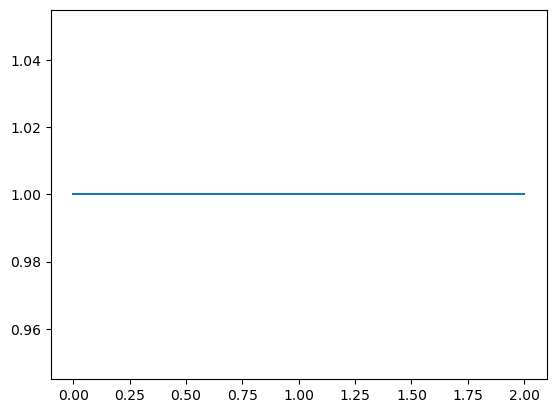

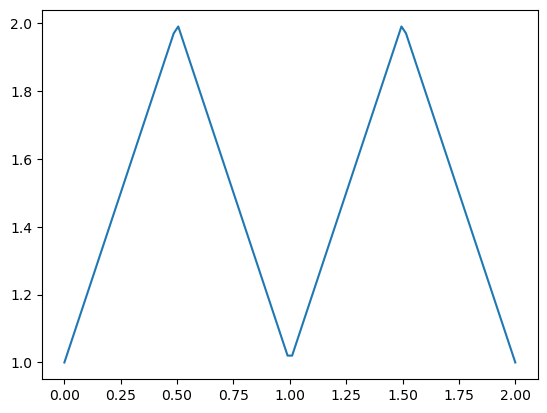

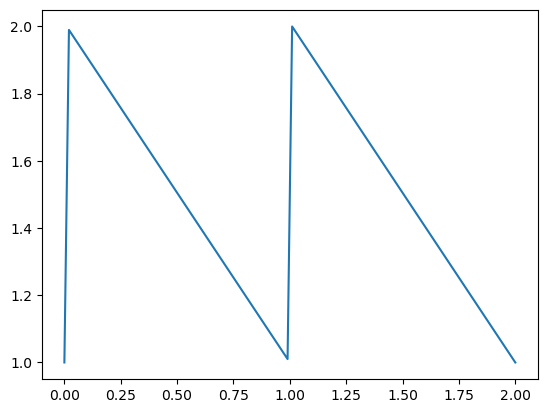

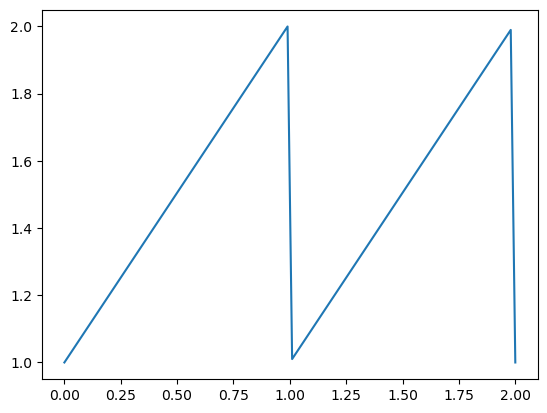

In [19]:
import matplotlib.pyplot as plt

times = np.linspace(0, 2, 100)

def try_mod(**kwargs):
    mod = FrequencyModulator(**kwargs)
    plt.figure()
    plt.plot(times, mod.evaluate(times))

# a modulator with a constant frequency
try_mod(base_frequency=1)

# a modulator with an equivalent rising and falling action
try_mod(base_frequency=1, frequency_delta=1)

# a modulator with a tiny rising action and large falling action
try_mod(base_frequency=1, frequency_delta=1, rising_fraction=0.01, falling_fraction=0.99)

# a modulator with a large rising action and tiny falling action
try_mod(base_frequency=1, frequency_delta=1, rising_fraction=0.99, falling_fraction=0.01)

### Oscillator
The oscillator simply consumes the frequency modulator and generates a waveform with a frequency equivalent to that defined by the frequency modulator.

In [45]:
class Oscillator:
    def __init__(self, frequency_modulator: FrequencyModulator, amplitude=1, phase_shift=0):
        self.frequency_modulator = frequency_modulator
        self.phase_shift = phase_shift
        self.amplitude = amplitude

    def evaluate(self, times):
        return self.amplitude * np.cos(
            2 * np.pi * self.frequency_modulator.integrate(times)
            + self.phase_shift
        )
    
    def __mul__(self, other):
        return MultOscillator(self, other)
    
class MultOscillator(Oscillator):
    def __init__(self, osc1, osc2):
        self.osc1 = osc1
        self.osc2 = osc2

    def evaluate(self, times):
        return self.osc1.evaluate(times) * self.osc2.evaluate(times)

### Testing The Oscillator
We'll generate a few different low-frequency waveforms, starting with a simple constant-frequency one.

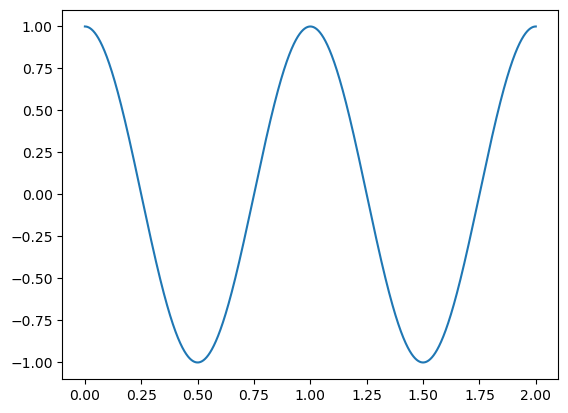

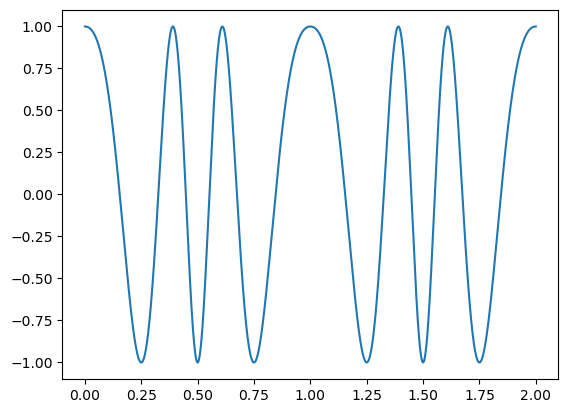

In [31]:
times = np.linspace(0, 2, 10000)


def try_mod_with_osc(**kwargs):
    plt.figure()
    mod = FrequencyModulator(**kwargs)
    osc = Oscillator(mod)
    plt.plot(times, osc.evaluate(times))


# a simple constant frequency oscillator, powered by a constant frequency modulator
try_mod_with_osc(base_frequency=1)

# an oscillator powered by a modulator that ramps up from 1-5 hertz and back down, 
# with equal time spent on rising and falling
try_mod_with_osc(base_frequency=1, frequency_delta=4)


## Signal Analysis

First, it may be worth proving a property of signals - multiplying signals with frequencies $f_0$ and $f_1$ results in a signal with frequency $f_0 + f_1$.

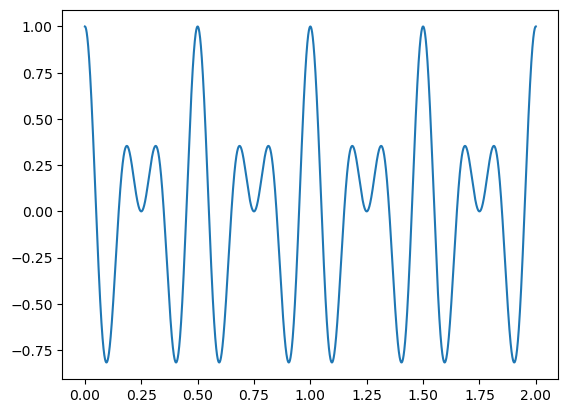

In [50]:
mod1 = FrequencyModulator(base_frequency = 1)
mod2 = FrequencyModulator(base_frequency = 5)

o1 = Oscillator(mod1)
o2 = Oscillator(mod2)
o3 = o1 * o2

plt.figure()
plt.plot(times, o3.evaluate(times))